# This is a Jupyter Notebook

In [1]:
# Import scikit-plot
import scikitplot as sp
from scikitplot import stats

sp.__version__

'0.5.0.dev0+git.20250430.079ba10'

In [2]:
import os
from pprint import pprint

import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
import time
import functools
import pickle
import logging
from abc import ABCMeta, abstractmethod
from typing import Callable, Any, Type, Union, Optional, List

# Configure logger
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)


class DecoratorMeta(ABCMeta):
    """Meta class for decorator behavior (expandable)."""
    pass


class DecoratorMixin(metaclass=DecoratorMeta):
    """
    A robust base for custom decorators.
    Handles function/class targets, serialization, and debug lifecycle hooks.
    Supports decorators with or without arguments.
    """
    _registry: List[Type["DecoratorMixin"]] = []

    def __init__(self, *args, **kwargs):
        if args and callable(args[0]):
            # Case where the decorator is used without parentheses
            self._target = args[0]
            self.args = args[1:] if len(args) > 1 else ()
            self.kwargs = kwargs
            self._called_directly = True
        else:
            self._target = None
            self.args = args
            self.kwargs = kwargs
            self._called_directly = False

        self.log(f"Initialized decorator: {self.__class__.__name__} with args: {self.args}, kwargs: {self.kwargs}")

    def __call__(self, obj: Optional[Union[Callable, Type]] = None) -> Union[Callable, Type, "DecoratorMixin"]:
        if not self._called_directly:
            # Called with arguments
            if obj is None:
                return self
            self._target = obj

        if not callable(self._target):
            raise TypeError(f"Expected function or class, got {type(self._target)}")

        self.log(f"Decorating object: {self.target_name}")

        if not self.should_apply(self._target):
            return self._target

        self.init_wrapper(self._target)
        return self.apply(self._target)

    def apply(self, obj: Union[Callable, Type]) -> Union[Callable, Type]:
        self.log("Applying decoration logic...")
        return self.decorate_class(obj) if isinstance(obj, type) else self._wrap_function(obj)

    def _wrap_function(self, func: Callable) -> Callable:
        @functools.wraps(func)
        def wrapped(*args, **kwargs):
            self.before(*args, **kwargs)
            try:
                result = self.wrapper(*args, **kwargs)
                self.after(result)
                return result
            except Exception as e:
                self.on_error(e)
                raise
        return wrapped

    # ===== Abstract / Extensible Methods =====

    @abstractmethod
    def wrapper(self, *args, **kwargs) -> Any:
        raise NotImplementedError("Implement wrapper() in subclass.")

    @abstractmethod
    def decorate_class(self, cls: type) -> type:
        raise NotImplementedError("Implement decorate_class() in subclass.")

    def should_apply(self, obj: Union[Callable, Type]) -> bool:
        if isinstance(obj, DecoratorMixin):
            self.log(f"Skipping decoration of already-decorated target: {obj}", level=logging.WARNING)
            return False
        self.log(f"Checking if should apply to: {self.target_name}")
        return True

    def init_wrapper(self, obj: Union[Callable, Type]):
        self.log(f"Initializing wrapper for {self.target_name} with args: {self.args}, kwargs: {self.kwargs}")

    def before(self, *args, **kwargs):
        self.log(f"Before call of {self.target_name} with args={args}, kwargs={kwargs}")

    def after(self, result: Any):
        self.log(f"After call of {self.target_name} with result={result}")

    def on_error(self, error: Exception):
        self.log(f"Error in {self.target_name}: {error}")

    # ===== Utility Methods =====

    @property
    def target_name(self) -> str:
        if hasattr(self._target, '__name__'):
            return self._target.__name__
        return str(self._target)

    def log(self, message: str, level=logging.DEBUG):
        logger.log(level, f"[{self.__class__.__name__}] {message}")

    @classmethod
    def register(cls, subclass: Type["DecoratorMixin"]) -> Type["DecoratorMixin"]:
        cls._registry.append(subclass)
        return subclass

    @classmethod
    def all_registered(cls) -> List[Type["DecoratorMixin"]]:
        return list(cls._registry)

    def chain(self, other: "DecoratorMixin") -> "DecoratorMixin":
        return ChainedDecorator(self, other)

    # ===== Serialization Support =====

    def __getstate__(self):
        state = self.__dict__.copy()
        state['_target'] = None
        return state

    def __setstate__(self, state):
        self.__dict__.update(state)
        self._target = None

    def serialize(self) -> bytes:
        return pickle.dumps(self)

    @classmethod
    def deserialize(cls, data: bytes) -> "DecoratorMixin":
        return pickle.loads(data)


# === Example Decorators ===

class TimeLogger(DecoratorMixin):
    def wrapper(self, *args, **kwargs):
        start = time.time()
        result = self._target(*args, **kwargs)
        end = time.time()
        self.log(f"{self.target_name} ran in {end - start:.4f}s", level=logging.INFO)
        return result

    def decorate_class(self, cls: type) -> type:
        self.log(f"TimeLogger applied to class: {cls.__name__}")
        return cls


class Retry(DecoratorMixin):
    def init_wrapper(self, obj, *args, **kwargs):
        self.tries = self.kwargs.get("tries", 3)
        self.delay = self.kwargs.get("delay", 0.5)
        self.log(f"Retry setup: tries={self.tries}, delay={self.delay}")

    def wrapper(self, *args, **kwargs):
        last_exception = None
        for attempt in range(1, self.tries + 1):
            try:
                self.log(f"Attempt {attempt} for {self.target_name}")
                return self._target(*args, **kwargs)
            except Exception as e:
                self.log(f"Attempt {attempt} failed: {e}")
                last_exception = e
                if attempt < self.tries:
                    time.sleep(self.delay)
        self.log(f"All retries failed for {self.target_name}")
        raise last_exception

    def decorate_class(self, cls: type) -> type:
        self.log("Retry does not support class decoration.")
        return cls


# === Usage ===

@TimeLogger()
@Retry(tries=3, delay=0.2)
@TimeLogger()
def might_fail():
    import random
    if random.random() < 0.7:
        raise ValueError("Random failure!")
    return "Success!"


# === Run ===

if __name__ == "__main__":
    try:
        print(might_fail())
    except Exception as e:
        print(f"Function failed: {e}")


DEBUG:__main__:[TimeLogger] Initialized decorator: TimeLogger with args: (), kwargs: {}
DEBUG:__main__:[TimeLogger] Initialized decorator: TimeLogger with args: (), kwargs: {}
DEBUG:__main__:[TimeLogger] Initialized decorator: TimeLogger with args: (), kwargs: {}
DEBUG:__main__:[Retry] Initialized decorator: Retry with args: (), kwargs: {'tries': 3, 'delay': 0.2}
DEBUG:__main__:[Retry] Initialized decorator: Retry with args: (), kwargs: {'tries': 3, 'delay': 0.2}
DEBUG:__main__:[Retry] Initialized decorator: Retry with args: (), kwargs: {'tries': 3, 'delay': 0.2}
DEBUG:__main__:[TimeLogger] Initialized decorator: TimeLogger with args: (), kwargs: {}
DEBUG:__main__:[TimeLogger] Initialized decorator: TimeLogger with args: (), kwargs: {}
DEBUG:__main__:[TimeLogger] Initialized decorator: TimeLogger with args: (), kwargs: {}
DEBUG:__main__:[TimeLogger] Decorating object: might_fail
DEBUG:__main__:[TimeLogger] Decorating object: might_fail
DEBUG:__main__:[TimeLogger] Decorating object: mig

Success!


In [16]:
import functools
import time
import random
import logging
from typing import Callable, Any, Tuple, Dict

# Setup logger
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger("Pipeline")

# === Base Transformer Step ===

class TransformerStep:
    def __init__(self, **variables):
        self.variables_ = variables or {}

    def set_variables(self, **kwargs):
        self.variables_.update(kwargs)

    def _inject_variables(self, args: Tuple, kwargs: Dict) -> Tuple[Tuple, Dict]:
        for k, v in self.variables_.items():
            kwargs.setdefault(k, v)
        return args, kwargs

    def fit_transform(self, *args, **kwargs) -> Tuple[Tuple, Dict]:
        """Override in subclass to transform args/kwargs"""
        return args, kwargs

    def postprocess(self, result):
        """Optional postprocessing"""
        return result

    def __call__(self, func: Callable):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            args, kwargs = self._inject_variables(args, kwargs)
            args, kwargs = self.fit_transform(*args, **kwargs)
            result = func(*args, **kwargs)
            return self.postprocess(result)
        return wrapper

    def log(self, msg, level=logging.INFO):
        logger.log(level, f"[{self.__class__.__name__}] {msg}")

# === Pipeline Class ===

class DecoratorPipeline:
    def __init__(self, *steps: TransformerStep):
        self.steps = steps

    def set_variables(self, **kwargs):
        for step in self.steps:
            step.set_variables(**kwargs)

    def __call__(self, func: Callable):
        for step in reversed(self.steps):
            func = step(func)
        return func

# === Example Steps ===

class TimeLogger(TransformerStep):
    def __call__(self, func):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            self.log(f"Calling {func.__name__}...")
            start = time.time()
            result = func(*args, **kwargs)
            end = time.time()
            self.log(f"{func.__name__} ran in {end - start:.4f}s", level=logging.DEBUG)
            return result
        return wrapper

class NormalizeInputs(TransformerStep):
    def fit_transform(self, *args, **kwargs):
        normalize = kwargs.get("normalize", True)
        self.log(f"Normalize = {normalize}")
        if normalize:
            args = tuple(float(x) / 100 for x in args)
        return args, kwargs

class Retry(TransformerStep):
    def __call__(self, func):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            tries = self.variables_.get("tries", 3)
            delay = self.variables_.get("delay", 0.2)
            last_exc = None
            for attempt in range(1, tries + 1):
                try:
                    self.log(f"Attempt {attempt}")
                    return func(*args, **kwargs)
                except Exception as e:
                    self.log(f"Failed attempt {attempt}: {e}", level=logging.WARNING)
                    last_exc = e
                    time.sleep(delay)
            raise last_exc
        return wrapper

# === Use Case ===

# Create pipeline
pipeline = DecoratorPipeline(
    TimeLogger(),
    Retry(tries=2, delay=0.1),
    NormalizeInputs()
)

# Attach to function
@pipeline
def process_data(a, b, normalize=True):
    if random.random() < 0.5:
        raise ValueError("Random failure!")
    return a + b

# Run with injected variables
try:
    print(process_data(150, 250, normalize=True))
except Exception as e:
    print("Function failed:", e)


INFO:Pipeline:[TimeLogger] Calling process_data...
INFO:Pipeline:[Retry] Attempt 1
INFO:Pipeline:[NormalizeInputs] Normalize = True


INFO:Pipeline:[Retry] Attempt 2
INFO:Pipeline:[NormalizeInputs] Normalize = True
DEBUG:Pipeline:[TimeLogger] process_data ran in 0.1041s


4.0


INFO:__main__:Step 1/5: extract_y
INFO:__main__:Step 1/5: extract_y
INFO:__main__:Step 1/5: extract_y
INFO:__main__:Executing extract_y
INFO:__main__:Executing extract_y
INFO:__main__:Executing extract_y
INFO:__main__:ytrue received y=[1, 0, 1, 0, 0]
INFO:__main__:ytrue received y=[1, 0, 1, 0, 0]
INFO:__main__:ytrue received y=[1, 0, 1, 0, 0]
INFO:__main__:Step 2/5: extract_y_pred
INFO:__main__:Step 2/5: extract_y_pred
INFO:__main__:Step 2/5: extract_y_pred
INFO:__main__:Executing extract_y_pred
INFO:__main__:Executing extract_y_pred
INFO:__main__:Executing extract_y_pred
INFO:__main__:ypred received y_pred=[0, 1, 0, 1, 1]
INFO:__main__:ypred received y_pred=[0, 1, 0, 1, 1]
INFO:__main__:ypred received y_pred=[0, 1, 0, 1, 1]
INFO:__main__:Step 3/5: extract_y_prob
INFO:__main__:Step 3/5: extract_y_prob
INFO:__main__:Step 3/5: extract_y_prob
INFO:__main__:Executing extract_y_prob
INFO:__main__:Executing extract_y_prob
INFO:__main__:Executing extract_y_prob
INFO:__main__:yprob received y_

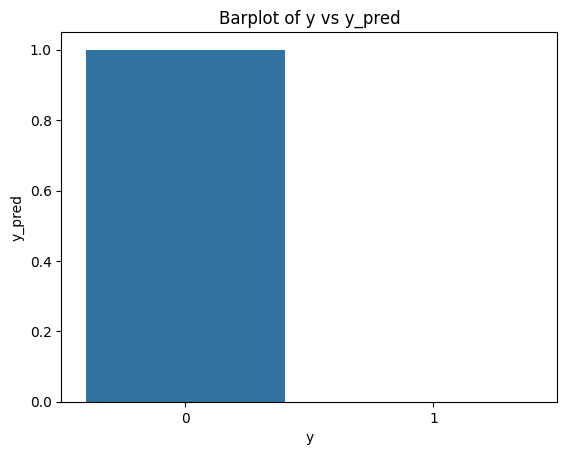

INFO:__main__:Step 5/5: do_lineplot
INFO:__main__:Step 5/5: do_lineplot
INFO:__main__:Step 5/5: do_lineplot
INFO:__main__:Executing do_lineplot
INFO:__main__:Executing do_lineplot
INFO:__main__:Executing do_lineplot


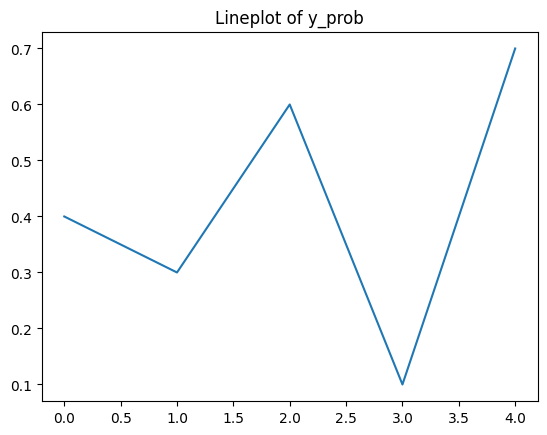

{}

In [19]:
import functools
import logging
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# --- Base classes ---

class PipeStep:
    def __init__(self, func):
        functools.update_wrapper(self, func)
        self.func = func

    def __call__(self, *args, **kwargs):
        logger.info(f"Executing {self.func.__name__}")
        return self.func(*args, **kwargs)

class Pipeline:
    def __init__(self, *steps: PipeStep):
        self.steps = list(steps)

    def __call__(self, *args, **kwargs):
        for i, step in enumerate(self.steps):
            logger.info(f"Step {i+1}/{len(self.steps)}: {step.__name__}")
            output = step(*args, **kwargs)
            if isinstance(output, tuple):
                args = output
                kwargs = {}
            elif isinstance(output, dict):
                args = ()
                kwargs = output
            else:
                args = (output,)
                kwargs = {}
        return output

    def add(self, step: PipeStep):
        self.steps.append(step)
        return self

    def draw(self, *args, **kwargs):
        return self(*args, **kwargs)

# --- Decorators for extracting args from kwargs ---

def ytrue(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        y = kwargs.get("y")
        logger.info(f"ytrue received y={y}")
        new_kwargs = {k: v for k, v in kwargs.items() if k != "y"}
        return func(*args, y=y, **new_kwargs)
    return PipeStep(wrapper)

def ypred(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        y_pred = kwargs.get("y_pred")
        logger.info(f"ypred received y_pred={y_pred}")
        new_kwargs = {k: v for k, v in kwargs.items() if k != "y_pred"}
        return func(*args, y_pred=y_pred, **new_kwargs)
    return PipeStep(wrapper)

def yprob(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        y_prob = kwargs.get("y_prob")
        logger.info(f"yprob received y_prob={y_prob}")
        new_kwargs = {k: v for k, v in kwargs.items() if k != "y_prob"}
        return func(*args, y_prob=y_prob, **new_kwargs)
    return PipeStep(wrapper)

# --- Example transformation / visualization steps ---

@ytrue
def extract_y(y=None, **kwargs):
    return {"y": y, **kwargs}

@ypred
def extract_y_pred(y_pred=None, **kwargs):
    return {"y_pred": y_pred, **kwargs}

@yprob
def extract_y_prob(y_prob=None, **kwargs):
    return {"y_prob": y_prob, **kwargs}

@PipeStep
def do_barplot(y=None, y_pred=None, **kwargs):
    if y is None or y_pred is None:
        logger.warning("Missing y or y_pred for barplot.")
        return kwargs
    data = pd.DataFrame({"y": y, "y_pred": y_pred})
    sns.barplot(x="y", y="y_pred", data=data)
    plt.title("Barplot of y vs y_pred")
    plt.show()
    return kwargs

@PipeStep
def do_lineplot(y=None, y_prob=None, **kwargs):
    if y_prob is None:
        logger.warning("Missing y_prob for lineplot.")
        return kwargs
    sns.lineplot(x=range(len(y_prob)), y=y_prob)
    plt.title("Lineplot of y_prob")
    plt.show()
    return kwargs

# --- Example usage ---

pipe = Pipeline(
    extract_y,
    extract_y_pred,
    extract_y_prob,
    do_barplot,
    do_lineplot,
)

y = [1, 0, 1, 0, 0]
y_pred = [0, 1, 0, 1, 1]
y_prob = [0.4, 0.3, 0.6, 0.1, 0.7]

pipe.draw(y=y, y_pred=y_pred, y_prob=y_prob)
